# Sentiment Analysis: Large Movie Review Dataset

This project is related to NLP. The most important and hardest part of an NLP project is pre-processing, which is why we are going to focus on that.

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files:

- `movies_review_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `movies_review_test_aai.csv`: Test dataset to test your model.

---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:` Use the target column as `positive`, that way the positive value will be indicated with a value of `1` and negative with a value of `0`. In this case, a split train/test is not necessary because the original data is already separated.

In [1]:
%load_ext autoreload
%autoreload 2
from src import data_utils
import os
import sys
import numpy as np
from gensim.models import Word2Vec
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb

sys.path.append(os.path.dirname(os.getcwd()))

from src import word2vec
from src import evaluation
from src import text_normalizer

np.random.seed(42)

train, test = data_utils.get_datasets()

[nltk_data] Downloading package stopwords to /Users/andi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/andi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/.venv/bin/spacy: line 2: /Users/andi/Documents/Anyone/Sprint_5/assignment 2/.venv/bin/python: No such file or directory
/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/.venv/bin/spacy: line 2: exec: /Users/andi/Documents/Anyone/Sprint_5/assignment 2/.venv/bin/python: cannot execute: No such file or directory


In [2]:
X_train, y_train, X_test, y_test = data_utils.split_data(train, test)

---
## 2. Normalize the data


In [4]:
stop_words = nltk.corpus.stopwords.words("english")

In [5]:

norm_train_reviews = text_normalizer.normalize_corpus(X_train, stopwords=stop_words)
norm_test_reviews = text_normalizer.normalize_corpus(X_test, stopwords=stop_words)

/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/src/text_normalizer.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  bs = BeautifulSoup(text, "html.parser")


**(\*) Functions will be checked using unit tests.**

---
## 3. Feature Engineering

You already have the pre-processed data, now you must vectorize them, because remember that the models only understand numbers. At this stage choose whether you want to vectorize with BoW or with TF-IDF. Later we will train our own embedding but for now we go with a more "classic" vectorization.


In [6]:
vectorizer= TfidfVectorizer(stop_words='english', max_features=5000)
apply_vectorizer = vectorizer.fit(norm_train_reviews)

train_features = apply_vectorizer.transform(norm_train_reviews)
test_features = apply_vectorizer.transform(norm_test_reviews)

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing) and apply everything we learned. Also if you want you can try several models, the more models you use and know better!

**In addition to training the model we ask you to show:**

- `Precision`
- `Recall`
- `F1-Score`
- `Classification Report`
- `Confusion Matrix`

**To do this you must complete the `get_performance` function of the `evaluation.py` script.**

**Also, you must complete the `plot_roc` function so that it can show:**

- `ROC Curve`
- `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [7]:
baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric=['logloss', 'auc'],  # Track both metrics
    learning_rate=0.1,               # Moderate learning rate
    max_depth=6,                     # Control tree depth to prevent overfitting
    min_child_weight=1,              # Minimum sum of instance weight in a child
    n_estimators=200,                # More trees for better learning
    subsample=0.8,                   # Prevent overfitting by using 80% of data per tree
    colsample_bytree=0.8,            # Use 80% of features per tree
    gamma=0.1,                       # Minimum loss reduction for split
    reg_alpha=0.1,                   # L1 regularization
    reg_lambda=1,                    # L2 regularization
    random_state=42,
    use_label_encoder=False          # Prevent warning messages
)


baseline_model.fit(train_features, y_train)
model_predictions = baseline_model.predict(test_features)

/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:28:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    model_predictions, y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.84396
Precision: 0.823538264730228
Recall: 0.87552
F1 Score: 0.8487339563379735

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.82      0.88      0.85     12500
           0       0.87      0.81      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  10155   2345
1   1556  10944


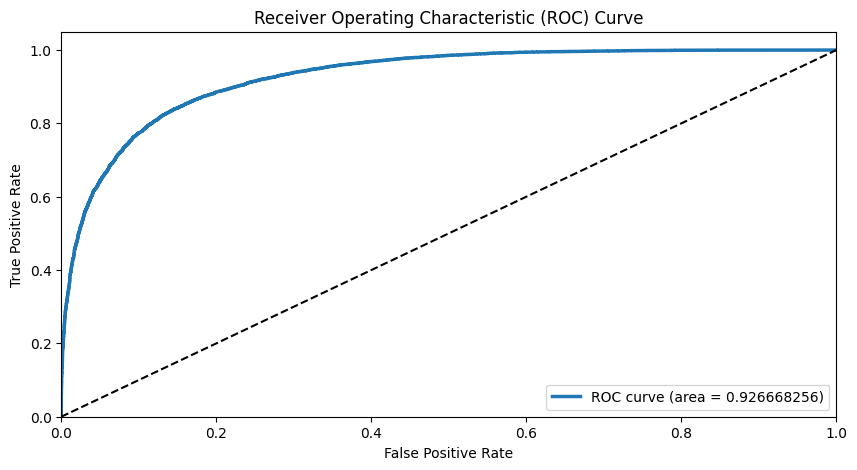

0.926668256

In [9]:
evaluation.plot_roc(baseline_model, y_test, test_features)

---

## 5. Classifying using K-Means

Let use tfidf features computed in last section as vector inputs for kmeans.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)

kmeans.fit(train_features)
print(f"Converged after {kmeans.n_iter_} iterations")
kmeans_predictions = kmeans.predict(test_features)

/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Converged after 28 iterations


In [11]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    [1 - el for el in kmeans_predictions], y_test
)

Model Performance metrics:
------------------------------
Accuracy: 0.56892
Precision: 0.5497602957315312
Recall: 0.76144
F1 Score: 0.6385134001945459

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.55      0.76      0.64     12500
           0       0.61      0.38      0.47     12500

    accuracy                           0.57     25000
   macro avg       0.58      0.57      0.55     25000
weighted avg       0.58      0.57      0.55     25000


Prediction Confusion Matrix:
------------------------------
      0     1
0  4705  7795
1  2982  9518


---
## 6. Feature Engineering with Custom Word Embedding

### Tokenize reviews and train your own Word Embedding

You are going to have to train your own word embedding, for this we are going to use the __gensim__ library. The only requirement we ask of you is that the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training your word embedding you must tokenize the corpus, this may take a bit depending on the size of the dataset and the tokenizer we use, if you want you can try the NLTK tokenizer called `ToktokTokenizer`, which turns out to be a little faster (we hope that this recommendation does not bias your work, try and use the ones you want)

In [17]:
from nltk.tokenize import word_tokenize

# Tokenize each review separately
tokenized_train = [
    word_tokenize(review.lower()) if isinstance(review, str) else []
    for review in norm_train_reviews
]

tokenized_test = [
    word_tokenize(review.lower()) if isinstance(review, str) else []
    for review in norm_test_reviews
]

w2v_vector_size = 200
# Now train the Word2Vec model
model_w2v = Word2Vec(
    sentences=tokenized_train,  # Now properly tokenized
    vector_size=w2v_vector_size,
    window=10,              
    min_count=2,           
    sg=1,                  
    hs=0,                  
    negative=10,           
    epochs=20,            
    workers=4,            
    alpha=0.025,          
    min_alpha=0.0001,     
    sample=1e-5           
)

### Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, you must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

To do this you must complete the `vectorize` function of the `word2vec.py` module.

In [18]:
w2v_train_features = word2vec.vectorizer(
    corpus=tokenized_train, model=model_w2v, num_features=w2v_vector_size
)
w2v_test_features = word2vec.vectorizer(
    corpus=tokenized_test, model=model_w2v, num_features=w2v_vector_size
)


### Modeling

Finally train a new model, it can be the same one you used before and compare the results you got using BoW/TF-IDF and Word2Vec.

In addition to training the model we ask you to show:

* `Accuracy`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value (later we will do a small minimum performance check with this value)`

In [22]:
best_model = baseline_model

# Train the model
best_model.fit(w2v_train_features, y_train)

# Make predictions
model_predictions = best_model.predict(w2v_test_features)


/Users/andi/Documents/Anyone/Sprint_5/sprint_05_jefferson_espejo/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:38:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [23]:
accuracy, precision, recall, f1_score = evaluation.get_performance(
    model_predictions, y_test
)


Model Performance metrics:
------------------------------
Accuracy: 0.84828
Precision: 0.8847547503314185
Recall: 0.80088
F1 Score: 0.8407306319546504

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.88      0.80      0.84     12500
           0       0.82      0.90      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000


Prediction Confusion Matrix:
------------------------------
       0      1
0  11196   1304
1   2489  10011


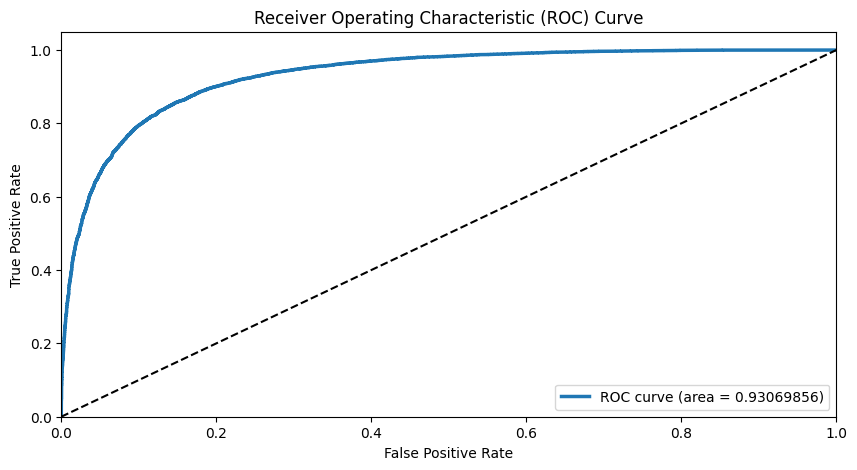

0.93069856

In [24]:
evaluation.plot_roc(best_model, y_test, w2v_test_features)


## 7. Predict data

In [25]:
from src import config
from pathlib import Path
DATASET_TEST_PREDICT = str(Path(config.DATASET_ROOT_PATH) / "movies_review_predict_aai.csv")
test_preds = best_model.predict_proba(w2v_test_features)[:, 1]
test["positive"] = test_preds
test.to_csv(DATASET_TEST_PREDICT, index=False)
